In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pylab as plt
import cPickle as pickle
import itertools
from matplotlib.path import Path
import matplotlib.patches as patches

In [2]:
from fuel.datasets.hdf5 import H5PYDataset
import fuel
datasource = 'handwriting'
datasource_dir = os.path.join(fuel.config.data_path, datasource)
datasource_fname = os.path.join(datasource_dir , datasource+'.hdf5')

Using gpu device 0: GeForce GT 650M


In [20]:
!mkdir -p {datasource_dir}

#Download

M. Liwicki and H. Bunke. IAM-OnDB - an on-line English sentence
database acquired from handwritten text on a whiteboard. In Proc. 8th
Int. Conf. on Document Analysis and Recognition, volume 2, pages 956–
961, 2005.

[You need to register to download](
http://www.iam.unibe.ch/fki/databases/iam-on-line-handwriting-database/download-the-iam-on-line-handwriting-database)

In [ ]:
%%bash -s "$datasource_dir"
cd $1
#wget http://<username>:<password>@www.iam.unibe.ch/~fkiwww/iamOnDB/data/lineStrokes-all.tar.gz
tar xfz lineStrokes-all.tar.gz

display few examples

In [4]:
import xml.etree.ElementTree as ET

def readPoints(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    points = []
    sets = 0
    for strokeSet in root.iter('StrokeSet'):
        assert sets == 0
        sets += 1
        for stroke in strokeSet.iter('Stroke'):
            start = 1
            for point in stroke.iter('Point'):
                points.append([int(point.attrib['x']), int(point.attrib['y']), start])
                start = 0
    points = np.array(points)
    points = np.hstack((points[1:,:2] - points[:-1,:2], points[1:,2,None]))  # keep deltas
    return points

In [5]:
from sketch import drawpoints

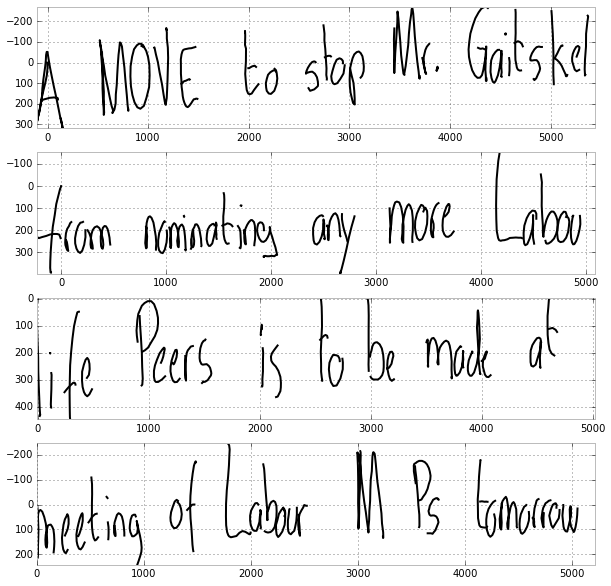

In [6]:
plt.figure(figsize=(10,10))
count = 1
M = 4
root = os.path.join(datasource_dir , "lineStrokes")
for dirpath, dnames, fnames in os.walk(root):
    for f in fnames:
        if count > M: break
        if f.endswith(".xml"):
            points = readPoints(os.path.join(dirpath,f))
            plt.subplot(4,1,count)
            count += 1
            drawpoints(points)
    if count > M:
        break

load all data

In [7]:
all_points = []
for dirpath, dnames, fnames in os.walk(root):
    for f in fnames:
        if f.endswith(".xml"):
            points = readPoints(os.path.join(dirpath,f))
            all_points.append(points)

In [8]:
len(all_points)

12195

In [9]:
lens = map(len, all_points)

In [10]:
min(lens),max(lens)

(30, 1939)

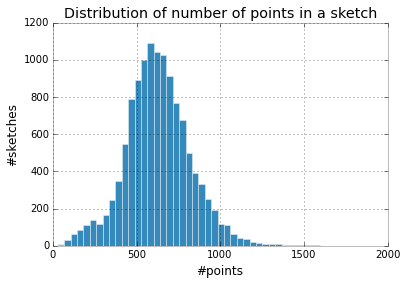

In [12]:
plt.hist(lens,bins=50)
plt.xlabel('#points')
plt.ylabel('#sketches')
plt.title('Distribution of number of points in a sketch');

clip sequence length to 1200

In [13]:
short_points_idx = filter(lambda i: len(all_points[i])<1200, range(len(all_points)))
N=len(short_points_idx)
N

12121

In [14]:
xys = np.vstack([all_points[i][:,:2] for i in short_points_idx])
xys.shape

(7545853, 2)

Normalize the std of the points' x & y

In [15]:
m = xys.mean(axis=0)
s = xys.std(axis=0)
m,s

(array([ 8.26222575,  0.12442145]), array([ 42.49033982,  37.24217178]))

In [16]:
X = np.empty((N,1200,3))
for i,j in enumerate(short_points_idx):
    p = all_points[j]
    n = len(p)
    X[i,:n,:2] = p[:,:2]/s
    X[i,n:,:2] = 0
    X[i,:n,2] =  p[:,2]
    X[i,n:,2] = 1

In [17]:
X.shape

(12121, 1200, 3)

shuffle samples

In [18]:
import random

In [19]:
X = X[random.sample(xrange(N),N)]

Save examples in fuel's hdf5 format

In [21]:
!rm {datasource_fname}

In [22]:
import h5py
fp = h5py.File(datasource_fname, mode='w')
image_features = fp.create_dataset('features', X.shape, dtype='float32')

In [23]:
image_features[...] = X

split to train and test

In [24]:
N_train = int(9*len(X)/10)
N_train

10908

In [25]:
split_dict = {
    'train': {'features': (0, N_train)},
    'test': {'features': (N_train, N)}
}
fp.attrs['split'] = H5PYDataset.create_split_array(split_dict)

In [26]:
fp.flush()
fp.close()

#Test

In [27]:
train_set = H5PYDataset(datasource_fname, which_set='train')

In [28]:
train_set.num_examples

10908

In [29]:
handle = train_set.open()
data = train_set.get_data(handle, slice(0, 16))
data[0].shape, data[0].dtype, data[0].max()

((16, 1200, 3), dtype('float32'), 19.863338)

In [30]:
train_set.close(handle)

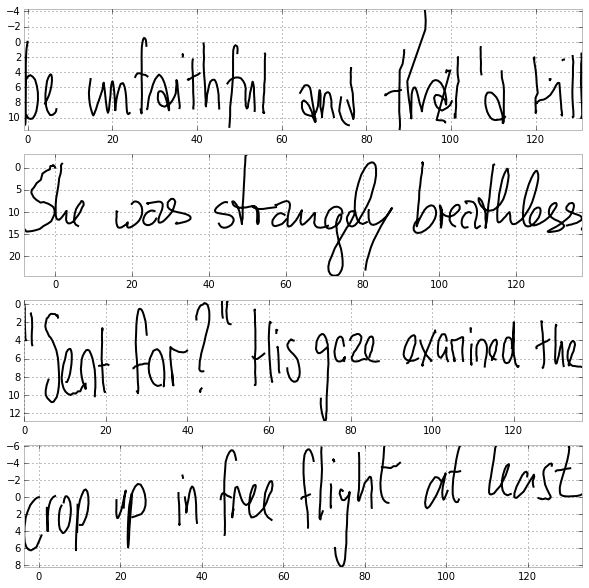

In [31]:
plt.figure(figsize=(10,10))
count = 1
M = 4
for points in data[0]:
    plt.subplot(4,1,count)
    count += 1
    drawpoints(points)
    if count > M: break